## Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

## Dataset Exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dataset = ImageFolder('/content/drive/MyDrive/Plant_Data_small/train_small')

In [4]:
valid_dataset = ImageFolder('/content/drive/MyDrive/Plant_Data_small/valid_small')

In [5]:
test_dataset = ImageFolder('/content/drive/MyDrive/Plant_Data_small/test_small')

In [7]:
len(train_dataset)

761

In [8]:
len(train_dataset.classes)

6

In [9]:
species = []

for n in train_dataset.classes:
    species.append(n)

In [10]:
species

['Almond', 'Banana', 'carex', 'cattails', 'coconut', 'parlor_palm']

## Creating Custom Dataset

To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

In [11]:
class PlantDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [12]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [13]:
train_ds = PlantDataset(train_dataset, train_transform)
val_ds = PlantDataset(valid_dataset, val_transform)
test_ds = PlantDataset(test_dataset, test_transform)

Lets quickly take a look into our training dataset

0


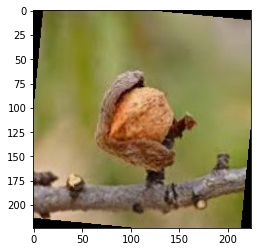

In [14]:
img, label = train_ds[6]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader 

In [15]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [16]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

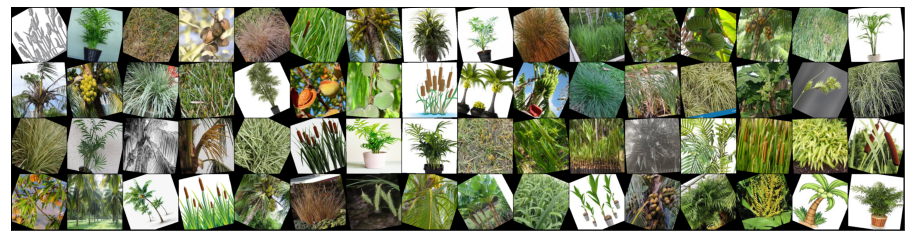

In [17]:
show_batch(train_dl)

## Network Architecture

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'train_loss':loss, 'train_acc': acc}
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["train_acc"], result["val_acc"]))
        

In [21]:
class Resnext32PreTrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(weights='IMAGENET1K_V2')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = Resnext32PreTrained()
model

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Resnext32PreTrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

## Moving Data to GPU

In [23]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [24]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [25]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model, device);   # Change model object here

cuda


## Training 

In [26]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([2, 5, 5, 0, 2, 3, 5, 5, 0, 5, 0, 3, 2, 3, 4, 4, 2, 5, 3, 3, 3, 1, 4, 0,
        2, 2, 3, 2, 0, 0, 3, 5, 4, 2, 0, 5, 3, 3, 1, 5, 5, 2, 2, 4, 4, 4, 3, 2,
        4, 2, 3, 3, 4, 4, 5, 5, 2, 2, 3, 2, 3, 3, 2, 3], device='cuda:0')
outs.shape : torch.Size([64, 7])
outs :  tensor([[-2.0781, -2.0061, -1.8935, -2.2203, -1.6925, -2.0029, -1.8190],
        [-1.7872, -1.9317, -1.9803, -1.9094, -1.9552, -1.9616, -2.1260],
        [-2.1239, -2.2676, -2.1369, -1.9852, -1.7969, -1.9824, -1.5235],
        [-1.9076, -1.8363, -2.2957, -1.9392, -1.9203, -1.7921, -2.0064],
        [-1.9780, -2.2009, -1.9266, -2.0605, -1.7981, -1.8717, -1.8425],
        [-2.1219, -1.8423, -1.9188, -1.6681, -1.9392, -2.1370, -2.0830],
        [-2.1022, -1.8927, -2.0012, -1.8836, -1.7435, -1.9946, -2.0482],
        [-1.9314, -1.9677, -1.8707, -2.0205, -1.9728, -1.9750, -1.8914],
        [-1.8854, -1.7519, -1.9829, -1.9106, -2.1711, -1.8740, -2.1073],
        [-1.

Now we'll train the model

In [27]:
from tqdm.notebook import tqdm

In [28]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        train_accs = []
        lrs = []
        for batch in tqdm(train_loader):
            train_result = model.training_step(batch)
            loss = train_result['train_loss']
            acc = train_result['train_acc']
            train_losses.append(loss)
            train_accs.append(acc)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [29]:
evaluate(model, val_dl)                 # change model object here

{'val_loss': 2.0029447078704834, 'val_acc': 0.07608695328235626}

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.Adam

max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [30]:
# set hyperparams for task 4 Fine-tuning
num_epochs = 10
opt_func = torch.optim.Adam

max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4

In [31]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9514, val_loss: 1.9491, train_acc: 0.1570, val_acc: 0.1739


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.8045, val_loss: 1.6792, train_acc: 0.4113, val_acc: 0.5217


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.3060, val_loss: 0.9930, train_acc: 0.7917, val_acc: 0.7609


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.6433, val_loss: 0.4802, train_acc: 0.8927, val_acc: 0.8804


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.2702, val_loss: 0.2633, train_acc: 0.9577, val_acc: 0.9239


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1527, val_loss: 0.1881, train_acc: 0.9670, val_acc: 0.9348


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0838, val_loss: 0.1727, train_acc: 0.9961, val_acc: 0.9348


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0727, val_loss: 0.1537, train_acc: 0.9935, val_acc: 0.9457


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0527, val_loss: 0.1524, train_acc: 0.9961, val_acc: 0.9457


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0571, val_loss: 0.1513, train_acc: 0.9948, val_acc: 0.9457


## Plotting history

In [32]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'train_acc', 'lrs'])

In [33]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])

### Loss v/s Epochs plot

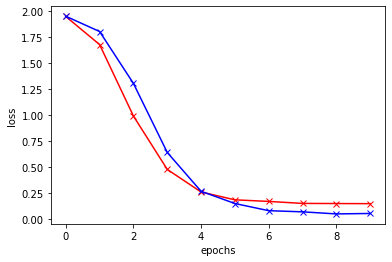

In [34]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Accuracy v/s Epochs plot

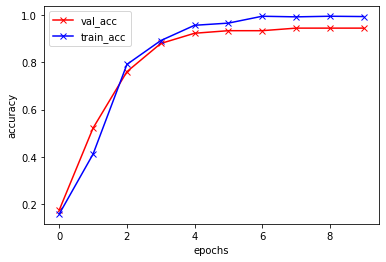

In [35]:
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="upper left")
plt.show()

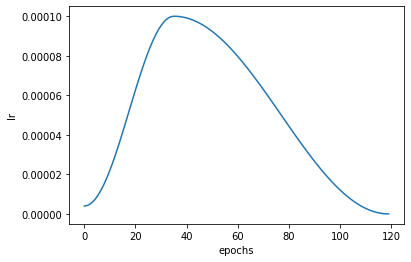

In [36]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

## Prediction

In [38]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', species[label], ' | Predicted :', species[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

Actual : Almond  | Predicted : Almond


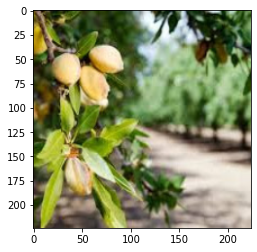

In [40]:
predict_single(*test_ds[6])

Actual : Almond  | Predicted : carex


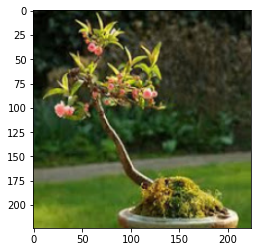

In [41]:
predict_single(*test_ds[1])

Actual : carex  | Predicted : carex


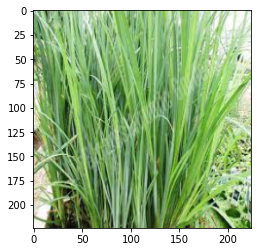

In [42]:
predict_single(*test_ds[93])

In [43]:
test_dl = DeviceDataLoader(test_dl, device)

In [44]:
result = evaluate(model, test_dl) # change model object here
result

{'val_loss': 0.10574144124984741, 'val_acc': 0.9770359992980957}

#Citation

Use starting code from: https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a

